## <u>*Regression Modelling for Severity as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error,accuracy_score,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm

In [29]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")

In [31]:
df.drop(["clm","X_OBSTAT_"],axis=1,inplace=True)

---

*Date preprocessing*

In [32]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [33]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat
14,1.66,0.484600,1,669.509999,9,3,1,1,6
16,1.51,0.993840,1,806.609999,9,3,0,5,4
17,0.76,0.539357,1,401.805451,3,3,1,2,4
40,1.89,0.654346,2,1811.709997,10,3,1,5,2
64,4.06,0.851472,1,5434.439987,10,2,1,5,3


*Define x and y*

In [34]:
x=df.drop(["claimcst0"],axis=1)
y=df["claimcst0"]

*Splitting data into training and testing subsets*

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3699, 8) and Y = (3699,) : 
Test data shape of X = (925, 8) and Y = (925,) : 


*Data Scalling*

In [36]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [37]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor()
                
                
            }

params={        
                "RandomForestRegressor":{
                    "n_estimators":[90,100,110], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.8,1],
                    "bootstrap":[True, False],                                                                                                    
                    "max_features":["sqrt","log2","auto"],                                     
                    "max_depth":[2,3,4],
                    "criterion":['poisson', 'squared_error','friedman_mse','absolute_error']
                    },

                "DecisionTreeRegressor": {
                    'criterion':['poisson', 'squared_error','friedman_mse','absolute_error'],
                    'splitter': ['best', 'random'],
                    "max_depth":[2,3,4], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.5,0.8],
                    #'max_features': [1,2,3,4],
                },
                
                "XGBRFRegressor":{
                    'learning_rate': [0.001,0.1,1],
                    'n_estimators': [90, 100, 110], 
                    "booster":["gbtree"],
                    'colsample_bytree': [0.5,0.8], 
                    'colsample_bynode': [0.5,0.8],
                    'random_state':[42]
                },

                
                "GradientBoostingRegressor":{
                    #'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate': [0.01,0.1,1],
                    'n_estimators': [90, 100, 110],
                    'subsample': [0.8,1],
                    #'criterion':['squared_error', 'friedman_mse'],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [0.8, 1],
                    'max_depth':[2,3,4],
                    #'max_features': ['sqrt', 'log2', 'auto']
                },
                "AdaBoostRegressor":{
                    'n_estimators': [45,50,55],
                    'learning_rate': [0.0001,0.001,0.01],
                    'loss':['linear','square','exponential'],
                    #'random_state':[42]
                    
                }
                
            }

In [38]:
def evaluate_models(x_train,y_train,x_test,y_test,models,params):            
                report = {}
                #report2={}
                for i in tqdm(range(len(list(models)))):
                    model=list(models.values())[i]
                    para=params[list(models.keys())[i]]

                    RandomSearchCV=RandomizedSearchCV(model,param_distributions= para,cv=3)
                    RandomSearchCV.fit(x_train,y_train)

                    model.set_params(**RandomSearchCV.best_params_)
                    model.fit(x_train,y_train)

                    y_train_prediction=model.predict(x_train)
                    y_test_prediction=model.predict(x_test)

                    model_train_root_mean_squared_error=root_mean_squared_error(y_train,y_train_prediction)
                    model_test_root_mean_squared_error=root_mean_squared_error(y_test,y_test_prediction)

                    model_train_r2_score=r2_score(y_train,y_train_prediction)
                    model_test_r2_score=r2_score(y_test,y_test_prediction)

                    #report[list(models.keys())[i]] = model_train_mean_absolute_percentage_error
                    report[list(models.keys())[i]] = (model_train_root_mean_squared_error,model_test_root_mean_squared_error,model_train_r2_score,model_test_r2_score,
                                                      RandomSearchCV.best_params_)


                return report

In [39]:
model_report:dict=evaluate_models(x_train, y_train, x_test, y_test,models=models,params=params)

100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


In [40]:
model_report_df=pd.DataFrame(model_report).iloc[:-1] 
model_report_df["metrices"]=["model_train_mean_absolute_percentage_error","model_test_mean_absolute_percentage_error","model_train_r2_score","model_test_r2_score"]

In [41]:
model_report_df

,RandomForestRegressor,DecisionTreeRegressor,XGBRFRegressor,GradientBoostingRegressor,AdaBoostRegressor,metrices
0,3607.941815,3607.941815,3322.566547,3520.383652,3405.497056,model_train_mean_absolute_percentage_error
1,3301.136379,3301.136379,3230.75513,3253.056718,3150.745894,model_test_mean_absolute_percentage_error
2,0.0,0.0,0.151937,0.047947,0.109073,model_train_r2_score
3,-0.002736,-0.002736,0.039565,0.02626,0.086546,model_test_r2_score


In [42]:
XGBRFRegressor_best_paramerts=[k[4] for i,k in model_report.items() if i=="XGBRFRegressor"]
XGBRFRegressor_best_paramerts

[{'random_state': 42,
  'n_estimators': 110,
  'learning_rate': 1,
  'colsample_bytree': 0.5,
  'colsample_bynode': 0.5,
  'booster': 'gbtree'}]

In [43]:
model=XGBRFRegressor(subsample=0.8,
                     random_state=42,
                     n_estimators=110,
                     colsample_bytree=.5,
                     colsample_bynode=.5,
                     booster="gbtree",
                     learning_rate=1
   ).fit(x_train,y_train)

In [44]:
predicted=model.predict(x_test)

In [49]:
model.feature_names=x.columns
importance=pd.concat([pd.DataFrame(model.feature_names,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.168528
1,exposure,0.278121
2,numclaims,0.115615
3,veh_body,0.084998
4,veh_age,0.085001
5,gender,0.079868
6,area,0.105845
7,agecat,0.082024


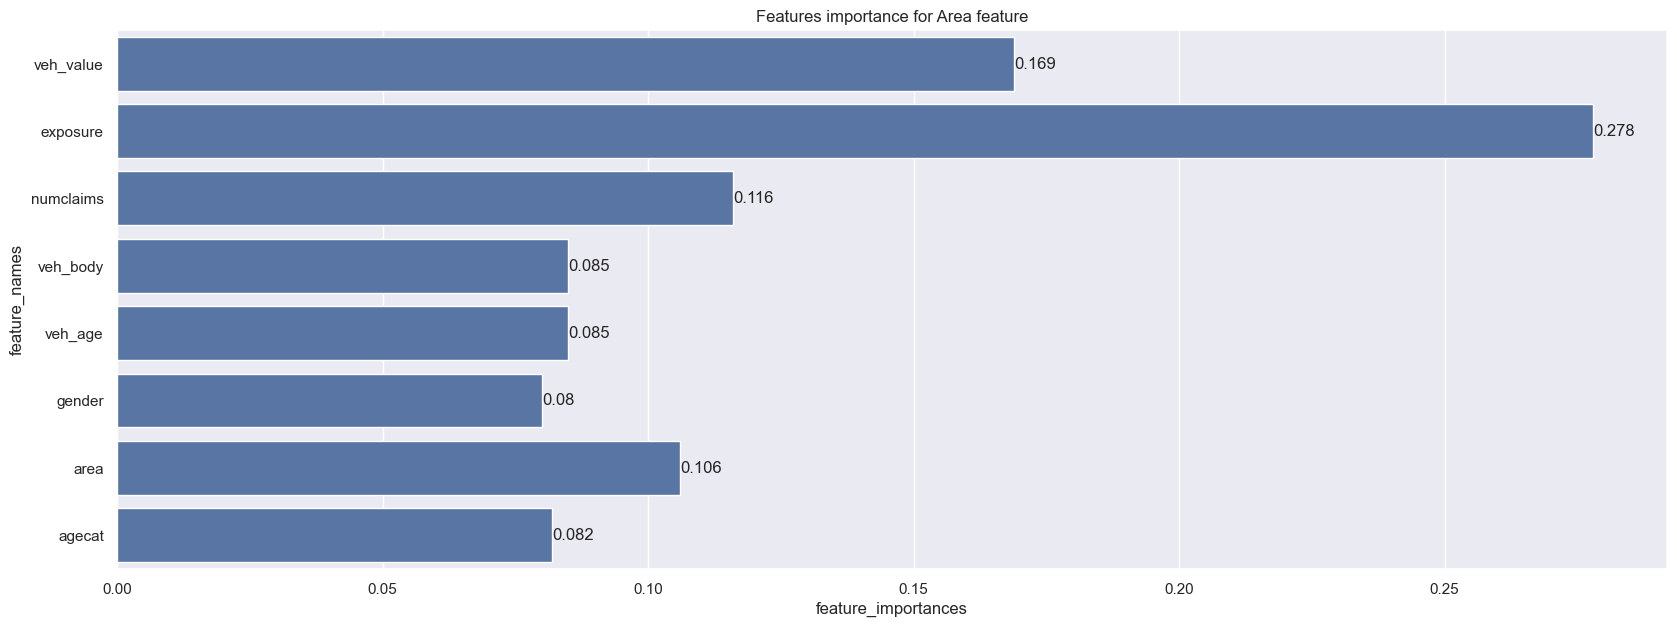

In [50]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Area feature')
ax.bar_label(ax.containers[0]);

---